In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Things to do 
<li>Clean the dataset convert catergoical data: to one hot encoded values(non ordinal data cols) and label encoded values (ordinal cols if there are any)</li>
<li>Visualize the dataset features</li>
<li>Look out for leakage cols, scheck the data for multi-colinearity</li>
<li>Remove cols with too many unique values like booking origin and route</li>
<li>Select simple models to train the data and get feature imporntacnes</li>
<li>Visualize the reuslts</li>

In [2]:
with open('customer_booking.csv') as f:
    print(f)

<_io.TextIOWrapper name='customer_booking.csv' mode='r' encoding='UTF-8'>


In [3]:
# install the chardet library
#!pip install chardet

# import the chardet library
import chardet 

# use the detect method to find the encoding
# 'rb' means read in the file as binary
with open("customer_booking.csv", 'rb') as file:
    print(chardet.detect(file.read(100000)))

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [4]:
df = pd.read_csv('customer_booking.csv',encoding='ISO-8859-1')

In [5]:
df.head(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [6]:
df.shape

(50000, 14)

In [7]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

# Let's view the summary statistics of the numerical columns

In [9]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [10]:
df['booking_complete'].value_counts()


booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [11]:
df['booking_complete'].value_counts() / len(df) *100

booking_complete
0    85.044
1    14.956
Name: count, dtype: float64

#### We have an imbalanced dataset, hence maybe we should think of using an oversampler or some similar techniques to handle the imbalance. 

###  Let us now start exploring the dataset and try to do some feature engineering

In [12]:
def wrangle(filepath):
    
    # Load the file into DataFrame from filepath
    df = pd.read_csv(filepath,encoding='ISO-8859-1')

    # Columns with high cardinality
    remove_cols = ['booking_origin','route']
    
    # Remove outlier from length_of_stay columns
    l_cut_stay , h_cut_stay = df['length_of_stay'].quantile([0.025,0.985])
    mask_stay = (df['length_of_stay']>l_cut_stay) & (df['length_of_stay']<h_cut_stay)
    df = df[mask_stay]

    # Drop col(s) from remove_cols list
    df = df.drop(remove_cols,axis=1)

    return df  


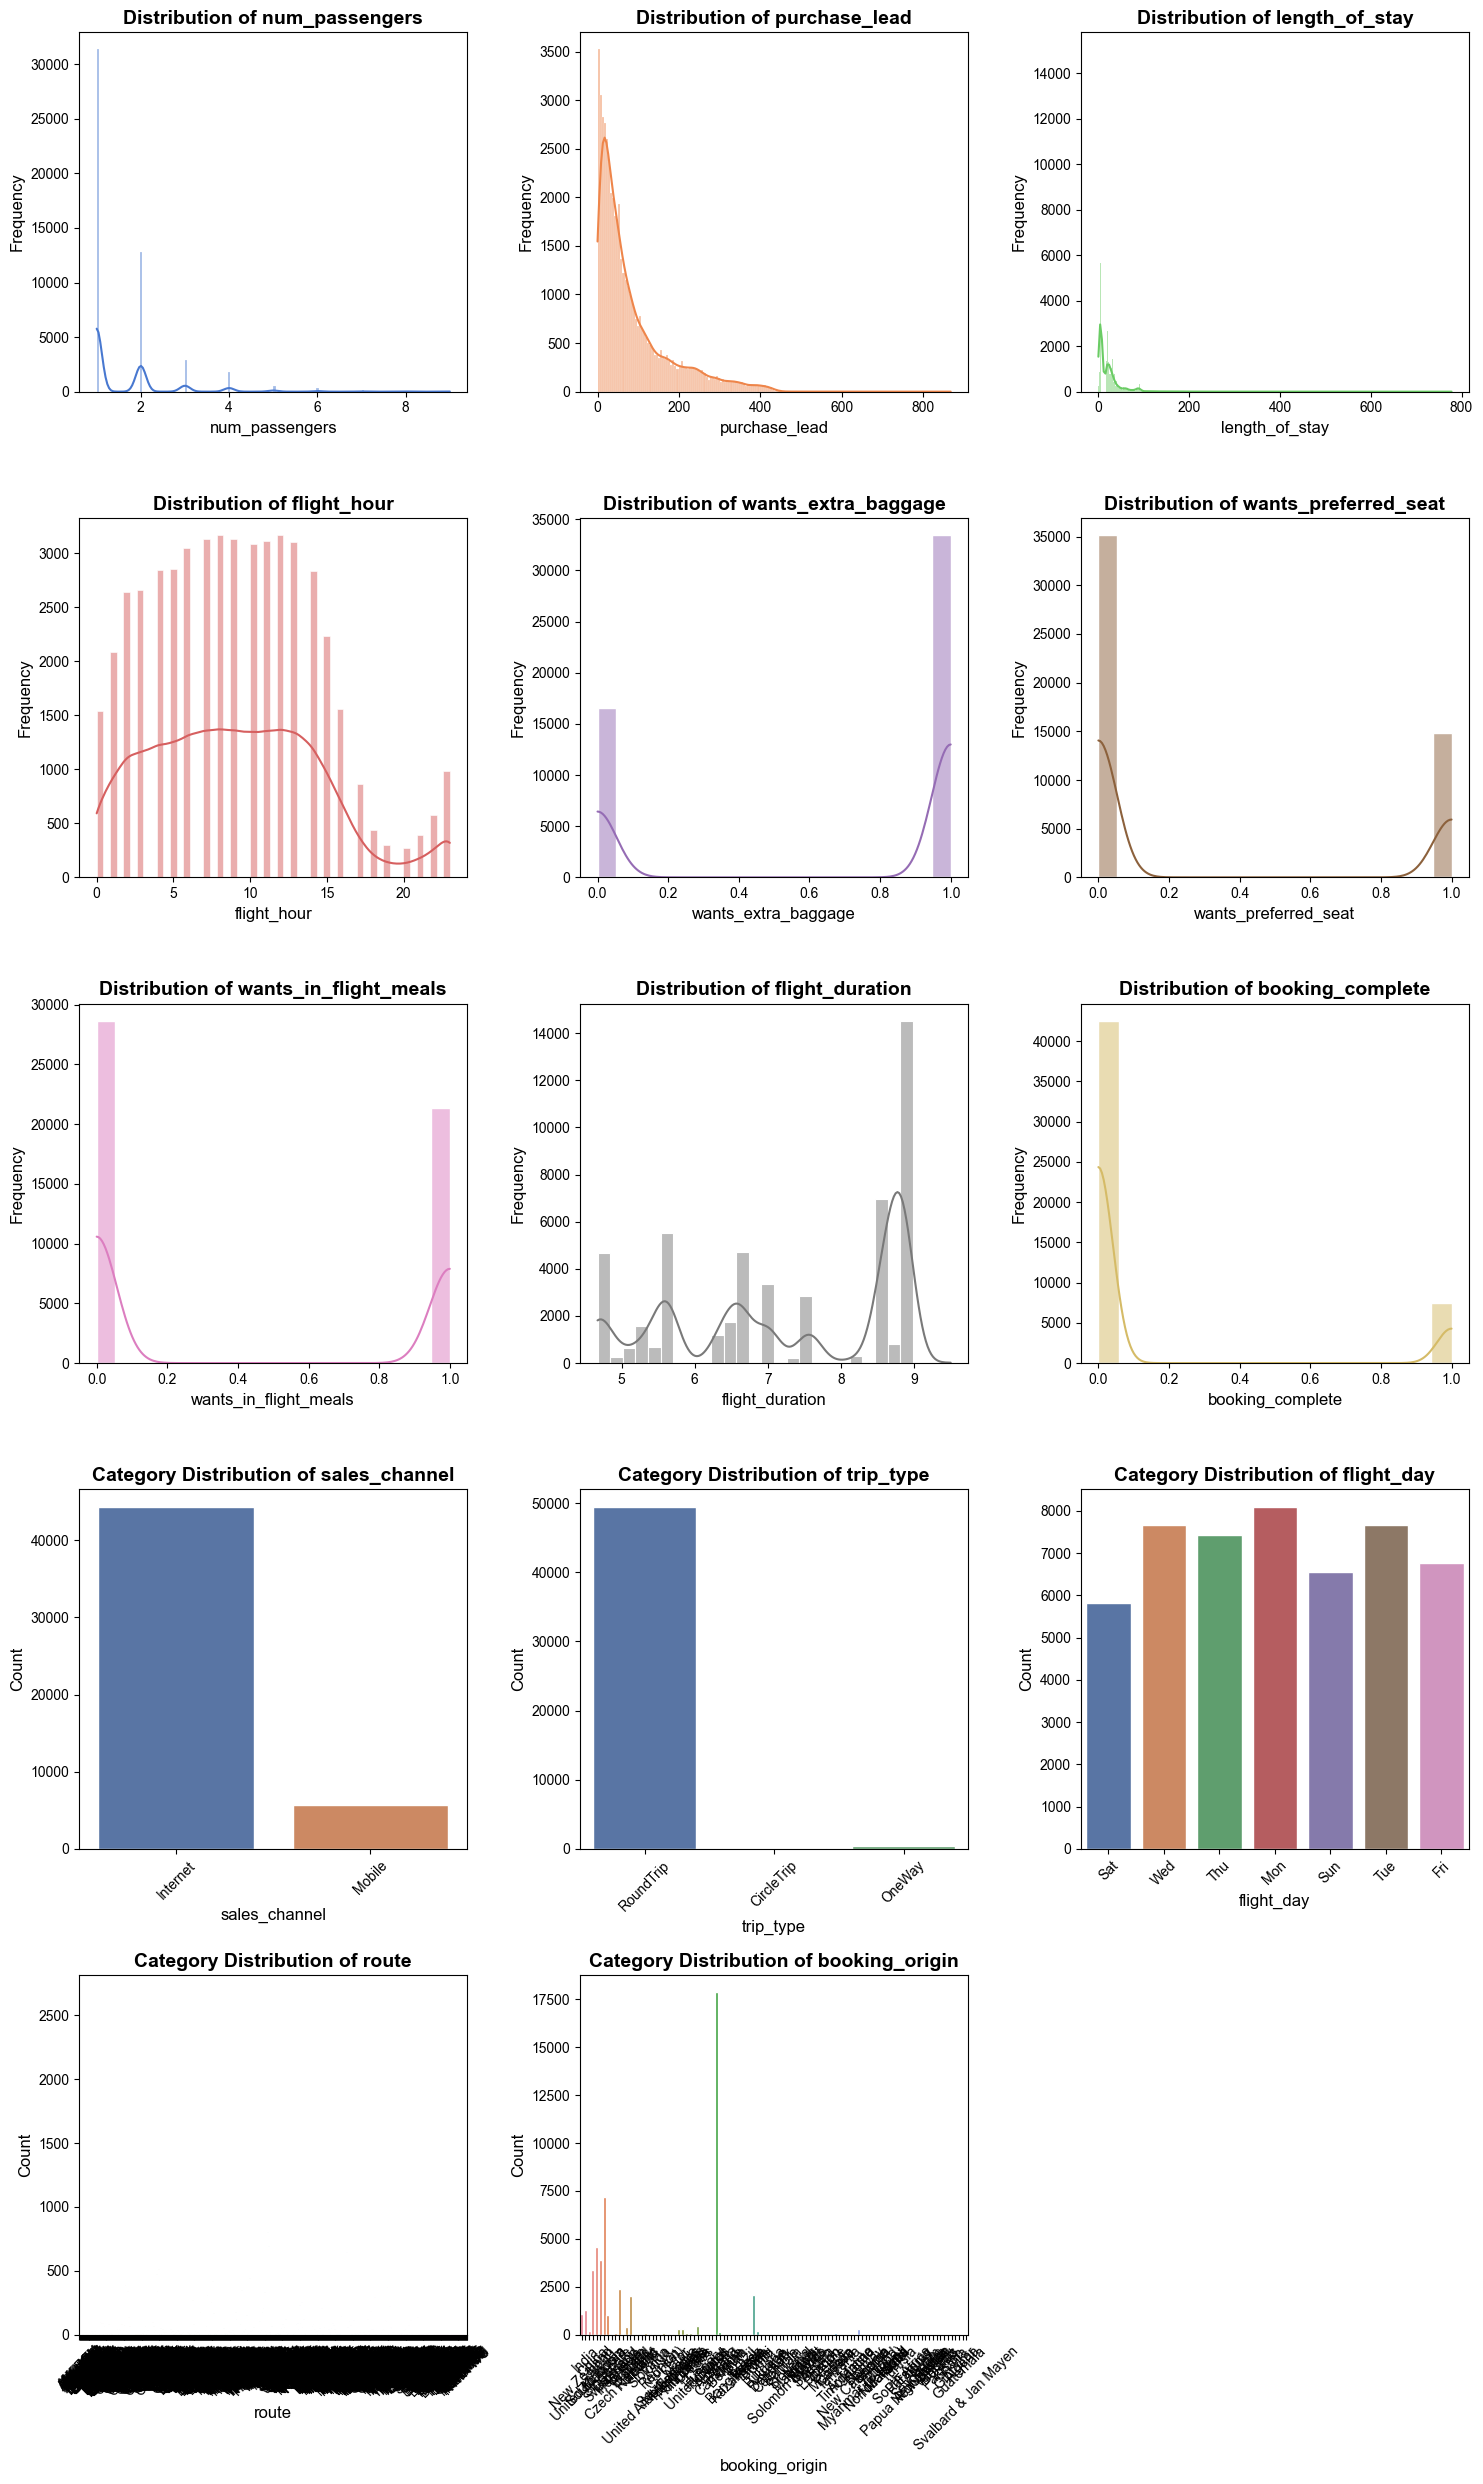

In [13]:
# Select numeric columns
numeric_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns

# Define the number of rows and columns for the grid
ncols = 3  # Number of columns in the grid
nrows = (len(numeric_columns) + len(categorical_columns) + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten to make indexing easier

# Set the seaborn style and color palette
sns.set(style="whitegrid")  # Set style for clean background
palette = sns.color_palette("muted")  # A soft yet vibrant color palette

# Loop through each numeric column and plot on a subplot
for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], kde=True, ax=axes[i], color=palette[i % len(palette)])  # Use a color from the palette
    axes[i].set_title(f'Distribution of {column}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Plot categorical columns as count plots
for i, column in enumerate(categorical_columns, start=len(numeric_columns)):
    sns.countplot(data=df, x=column, ax=axes[i], hue=column)  # Use a color from the palette
    axes[i].set_title(f'Category Distribution of {column}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

### Looking through the count plots and the histograms above allows us to have a glimpse at the distirubtion data cols in the dataset. 
<p>We observe high cardinality in the last two plots compared to all the other categorical count plots.</p>
<p>Length of stay data col might have some outliers that we might want to exclude from the model.</p>

## Outlier removal from 'length_of_stay' 

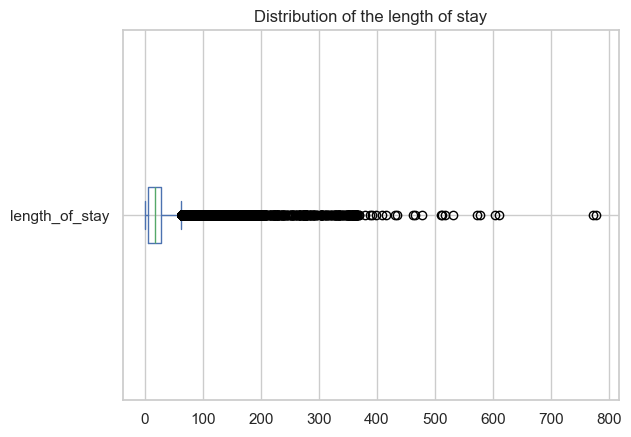

In [14]:
df['length_of_stay'].plot(kind='box',vert=False)
plt.title('Distribution of the length of stay');

In [15]:
df.loc[df['length_of_stay']>df['length_of_stay'].quantile(0.98)].groupby('booking_complete').size()

booking_complete
0    870
1    122
dtype: int64

In [16]:
l_cut_stay , h_cut_stay = df['length_of_stay'].quantile([0.025,0.985])
mask_stay = (df['length_of_stay']>l_cut_stay) & (df['length_of_stay']<h_cut_stay)
df[mask_stay]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


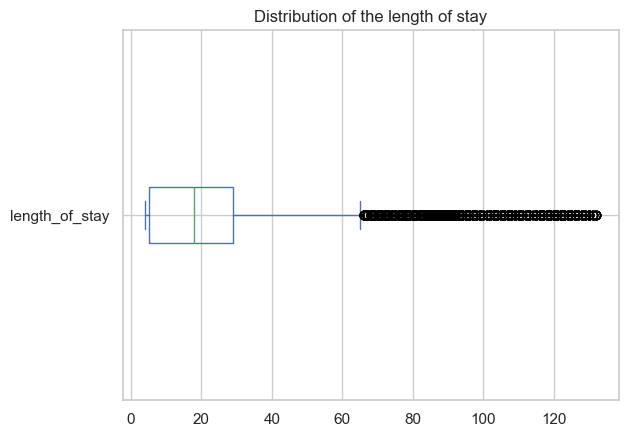

In [17]:
df[mask_stay]['length_of_stay'].plot(kind='box',vert=False)
plt.title('Distribution of the length of stay');

The resultant still has outliers but not as prominent as the initial graph.

## High Cardinality Columns

In [18]:
df['booking_origin'].value_counts()

booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

In [19]:
df['route'].value_counts()

route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

The above two colums are not ordinal therefore is not meaningful to be label encoded, and if we do one hot encoding on both of those columns. Then our feature matrix x will have very high dimensionality (900+) features this will not only result in longer training times but might also produce a model that will not generalize well to the data. So, these two columns will be dropped.

#### Preparing the dataset for model building

In [20]:
filepath = 'customer_booking.csv'
df = wrangle(filepath=filepath)
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,1,0,1,5.52,0


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler

X = df.drop('booking_complete',axis=1)
y = df['booking_complete']

In [22]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,random_state=42,test_size=0.2)

Use a random over sampler to deal with the imabalanced classes in the dataset

In [23]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape,y_train_over.shape)

(61748, 11) (61748,)


## Logistic Regression

In [24]:
# 
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=2000)
)
model_logr

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [25]:
cv_acc_scores = cross_val_score(model_logr, X_train_over, y_train_over, n_jobs=-1, cv=5)
cv_acc_scores

array([0.60307692, 0.6059919 , 0.60040486, 0.59883391, 0.6003725 ])

In [26]:
model_logr.fit(X_train_over,y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sales_channel', 'trip_type',
                                     'flight_day'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [27]:
model_logr.score(X_test,y_test), model_logr.score(X_train_over,y_train_over)

(0.6009939260077305, 0.6019466217529312)

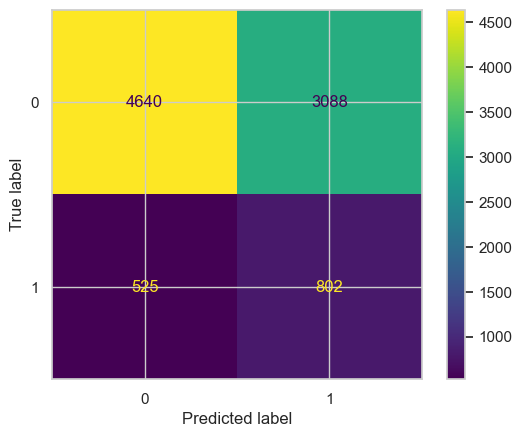

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model_logr,X_test,y_test);

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,model_logr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72      7728
           1       0.21      0.60      0.31      1327

    accuracy                           0.60      9055
   macro avg       0.55      0.60      0.51      9055
weighted avg       0.80      0.60      0.66      9055



### At an accuracy score of a little over 60%, the performance of the model is below satisfactory. There are too many False Positives

## RandomForest Model 

In [30]:
model_rft = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(random_state=42)
)
model_rft


Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [84]:
params = {
    'randomforestclassifier__n_estimators': range(50,100,25),
    'randomforestclassifier__max_depth': range(20,50,10),
    'randomforestclassifier__min_samples_split': range(4,10,2),
    'randomforestclassifier__min_samples_leaf': range(4,10,2)
}
params

{'randomforestclassifier__n_estimators': range(50, 100, 25),
 'randomforestclassifier__max_depth': range(20, 50, 10),
 'randomforestclassifier__min_samples_split': range(4, 10, 2),
 'randomforestclassifier__min_samples_leaf': range(4, 10, 2)}

In [85]:
model = GridSearchCV(model_rft,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1,
                     verbose=1)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(20, 50, 10),
                         'randomforestclassifier__min_samples_leaf': range(4, 10, 2),
                         'randomforestclassifier__min_samples_split': range(4, 10, 2),
                         'randomforestclassifier__n_estimators': range(50, 100, 25)},
             verbose=1)

In [86]:
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(20, 50, 10),
                         'randomforestclassifier__min_samples_leaf': range(4, 10, 2),
                         'randomforestclassifier__min_samples_split': range(4, 10, 2),
                         'randomforestclassifier__n_estimators': range(50, 100, 25)},
             verbose=1)

In [103]:
rft_cv_results = pd.DataFrame(model.cv_results_)
rft_cv_results.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,7.302247,1.023547,0.350480,0.016935,40,4,8,75,"{'randomforestclassifier__max_depth': 40, 'ran...",0.885020,0.893684,0.888178,0.887116,0.891813,0.889162,0.003155,1
39,7.145412,0.608884,0.391289,0.076178,40,4,6,75,"{'randomforestclassifier__max_depth': 40, 'ran...",0.885020,0.893684,0.888178,0.887116,0.891813,0.889162,0.003155,1
37,6.733119,0.287791,0.408293,0.065581,40,4,4,75,"{'randomforestclassifier__max_depth': 40, 'ran...",0.885020,0.893684,0.888178,0.887116,0.891813,0.889162,0.003155,1
21,6.883553,0.482293,0.338277,0.038274,30,4,6,75,"{'randomforestclassifier__max_depth': 30, 'ran...",0.884777,0.896275,0.887449,0.887440,0.889789,0.889146,0.003902,4
19,6.750123,0.663387,0.377685,0.032329,30,4,4,75,"{'randomforestclassifier__max_depth': 30, 'ran...",0.884777,0.896275,0.887449,0.887440,0.889789,0.889146,0.003902,4
23,6.760925,0.564792,0.336276,0.051833,30,4,8,75,"{'randomforestclassifier__max_depth': 30, 'ran...",0.884777,0.896275,0.887449,0.887440,0.889789,0.889146,0.003902,4
22,4.616441,0.315645,0.258259,0.029157,30,4,8,50,"{'randomforestclassifier__max_depth': 30, 'ran...",0.883644,0.895142,0.885101,0.884039,0.889546,0.887494,0.004363,7
20,4.778679,0.739826,0.255658,0.040715,30,4,6,50,"{'randomforestclassifier__max_depth': 30, 'ran...",0.883644,0.895142,0.885101,0.884039,0.889546,0.887494,0.004363,7
18,4.813486,0.242058,0.273863,0.042696,30,4,4,50,"{'randomforestclassifier__max_depth': 30, 'ran...",0.883644,0.895142,0.885101,0.884039,0.889546,0.887494,0.004363,7
38,4.545225,0.391383,0.273462,0.085410,40,4,6,50,"{'randomforestclassifier__max_depth': 40, 'ran...",0.880972,0.893522,0.884211,0.883067,0.890598,0.886474,0.004768,10


In [88]:
#rft_cv_results.to_csv('task2_BA_rf_ovefit_sol_trial1.csv')

In [80]:
sec_best_param_dict = {'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 50}

best_param_dict = {'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 50}



{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 50}

In [31]:
model_test = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(random_state=42,max_depth=40,n_estimators=50)
)
model_test.fit(X_train_over,y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sales_channel', 'trip_type',
                                     'flight_day'],
                               use_cat_names=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=50,
                                        random_state=42))])

In [44]:
model_test.score(X_test,y_test)

0.8293760353395914

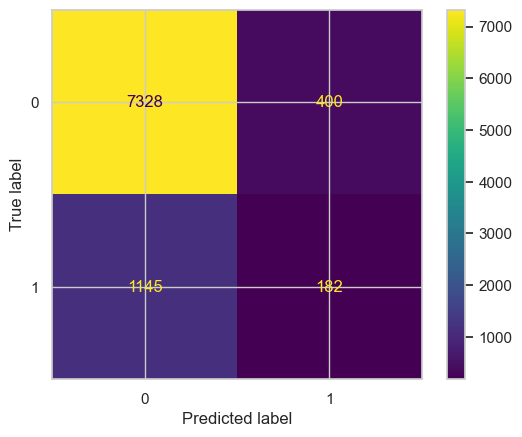

In [45]:
ConfusionMatrixDisplay.from_estimator(model_test,X_test,y_test);

In [46]:
best_params_rft = model.best_params_
best_params_rft

NameError: name 'model' is not defined

In [90]:
print(f'The best score for the model was: {model.best_score_}')

The best score for the model was: 0.8891624118132464


In [91]:
best_estimator = model.best_estimator_
best_estimator

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sales_channel', 'trip_type',
                                     'flight_day'],
                               use_cat_names=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, min_samples_leaf=4,
                                        min_samples_split=4, n_estimators=75,
                                        random_state=42))])

In [92]:
acc_score_test = best_estimator.score(X_test,y_test)
acc_score_test

0.7863059083379348

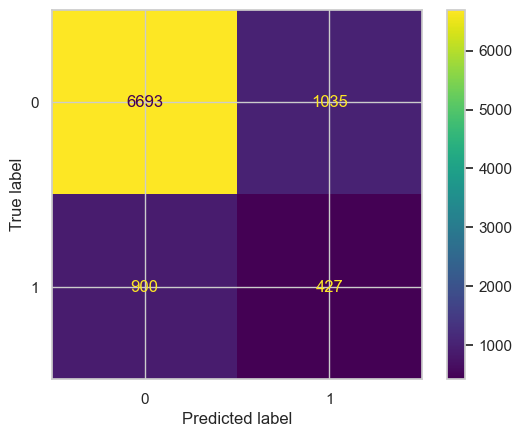

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_estimator,X_test,y_test);

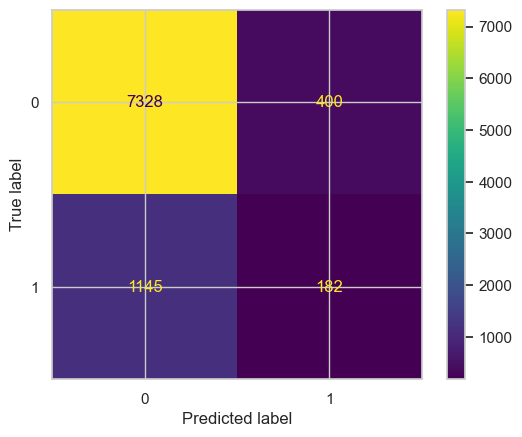

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_test,X_test,y_test);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,model.best_estimator_.predict(X_test)))

In [ ]:
print(classification_report(y_test,model_test.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      7728
           1       0.31      0.14      0.19      1327

    accuracy                           0.83      9055
   macro avg       0.59      0.54      0.55      9055
weighted avg       0.78      0.83      0.80      9055



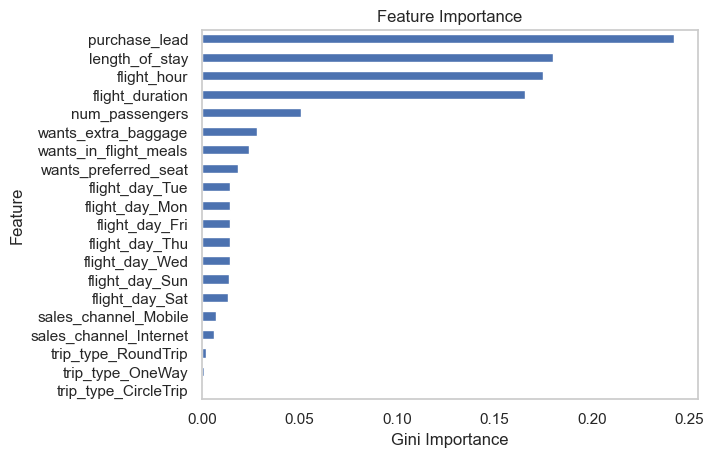

In [95]:
features = model.best_estimator_.named_steps.onehotencoder.get_feature_names_out()
importances = model.best_estimator_.named_steps.randomforestclassifier.feature_importances_
feat_imp = pd.Series(importances,index=features).sort_values()

feat_imp.tail(30).plot(kind='barh',grid=False)
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importance');

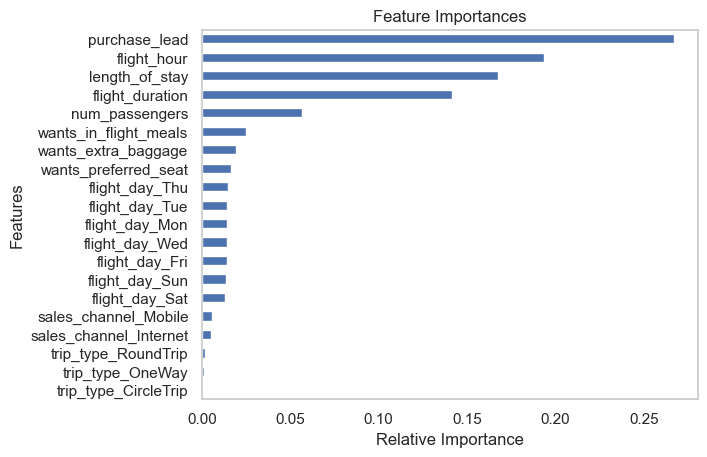

In [57]:
features = model_test.named_steps.onehotencoder.get_feature_names_out()
importances = model_test.named_steps.randomforestclassifier.feature_importances_
feat_imp = pd.Series(importances,index=features).sort_values()

feat_imp.tail(30).plot(kind='barh',grid=False)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances');

### XGBoost model 

In [43]:

clf_xgboost = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    GradientBoostingClassifier(random_state=42)
)

In [48]:
params = {
    'gradientboostingclassifier__max_depth': range(10,31,5),
    'gradientboostingclassifier__n_estimators': range(20,41,5),

}
params

{'gradientboostingclassifier__max_depth': range(10, 31, 5),
 'gradientboostingclassifier__n_estimators': range(20, 41, 5)}

In [49]:
model_xgb = GridSearchCV(clf_xgboost,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1,
                     verbose=1)
model_xgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(10, 31, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 41, 5)},
             verbose=1)

In [50]:
model_xgb.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(10, 31, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 41, 5)},
             verbose=1)

In [51]:
cv_results_xgb = pd.DataFrame(model_xgb.cv_results_)
cv_results_xgb.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,71.222319,3.574636,0.178052,0.017725,20,40,"{'gradientboostingclassifier__max_depth': 20, ...",0.939838,0.940081,0.943968,0.945664,0.945907,0.943091,0.002644,1
13,60.843071,4.095933,0.154445,0.012851,20,35,"{'gradientboostingclassifier__max_depth': 20, ...",0.936194,0.934980,0.942429,0.941777,0.941372,0.939350,0.003115,2
12,51.226449,4.563649,0.133039,0.007901,20,30,"{'gradientboostingclassifier__max_depth': 20, ...",0.934413,0.931741,0.940081,0.938861,0.938133,0.936646,0.003097,3
9,41.245968,1.842525,0.118635,0.013941,15,40,"{'gradientboostingclassifier__max_depth': 15, ...",0.934737,0.936032,0.938138,0.936594,0.936918,0.936484,0.001113,4
11,39.428409,3.819906,0.119235,0.011218,20,25,"{'gradientboostingclassifier__max_depth': 20, ...",0.929879,0.928745,0.937652,0.936675,0.932221,0.933034,0.003566,5
8,34.961301,1.493454,0.122836,0.029534,15,35,"{'gradientboostingclassifier__max_depth': 15, ...",0.928988,0.931498,0.931336,0.931411,0.933031,0.931253,0.001295,6
19,63.139169,1.698201,0.185455,0.014239,25,40,"{'gradientboostingclassifier__max_depth': 25, ...",0.929069,0.928583,0.931417,0.927848,0.934084,0.930200,0.002280,7
18,54.099890,2.026659,0.158047,0.012981,25,35,"{'gradientboostingclassifier__max_depth': 25, ...",0.927773,0.927206,0.929069,0.927444,0.931330,0.928565,0.001525,8
10,29.161818,2.143387,0.106632,0.011238,20,20,"{'gradientboostingclassifier__max_depth': 20, ...",0.923644,0.924211,0.933441,0.932140,0.928091,0.928305,0.003991,9
17,45.474357,2.100190,0.133439,0.005819,25,30,"{'gradientboostingclassifier__max_depth': 25, ...",0.927773,0.925992,0.926235,0.924690,0.930359,0.927010,0.001940,10


In [52]:
best_params_xgb = model_xgb.best_params_
best_params_xgb

{'gradientboostingclassifier__max_depth': 20,
 'gradientboostingclassifier__n_estimators': 40}

In [53]:
best_estimator_xgb = model_xgb.best_estimator_
best_estimator_xgb

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sales_channel', 'trip_type',
                                     'flight_day'],
                               use_cat_names=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=20, n_estimators=40,
                                            random_state=42))])

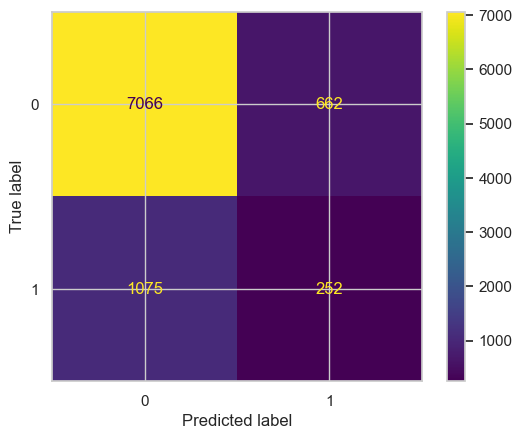

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_estimator_xgb,X_test,y_test);

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_test,model_xgb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7728
           1       0.28      0.19      0.22      1327

    accuracy                           0.81      9055
   macro avg       0.57      0.55      0.56      9055
weighted avg       0.78      0.81      0.79      9055



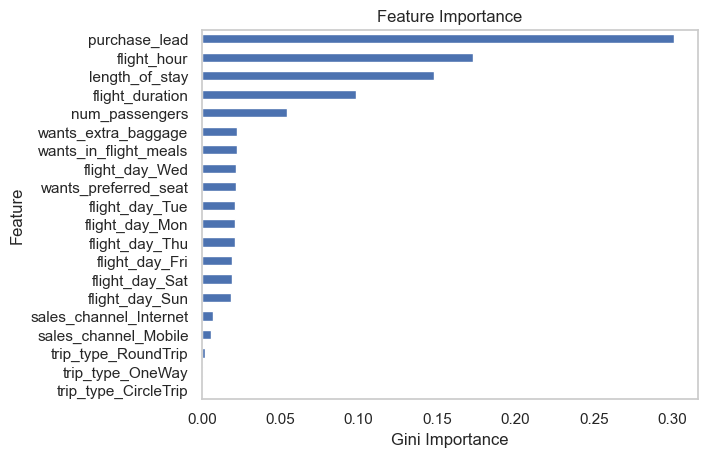

In [56]:
features = model_xgb.best_estimator_.named_steps.onehotencoder.get_feature_names_out()
importances = model_xgb.best_estimator_.named_steps.gradientboostingclassifier.feature_importances_
feat_imp = pd.Series(importances,index=features).sort_values()

feat_imp.tail(30).plot(kind='barh',grid=False)
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importance');